In [228]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from xgboost import XGBRegressor

## Read in the data

- timestamp - A timestamp for the minute covered by the row.
- Asset_ID - An ID code for the cryptoasset.
- Count - The number of trades that took place this minute.
- Open - The USD price at the beginning of the minute.
- High - The highest USD price during the minute.
- Low - The lowest USD price during the minute.
- Close - The USD price at the end of the minute.
- Volume - The number of cryptoasset units traded during the minute.
- VWAP - The volume weighted average price for the minute.
- Target - 15 minute residualized returns. 

In [229]:
crypto_df = pd.read_csv('Resources/train.csv')
crypto_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [230]:
asset_df = pd.read_csv('Resources/asset_details.csv')
asset_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Clean the dataset

In [231]:
# check the datatypes and counts of each column
crypto_df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int64  
 1   Asset_ID   24236806 non-null  int64  
 2   Count      24236806 non-null  float64
 3   Open       24236806 non-null  float64
 4   High       24236806 non-null  float64
 5   Low        24236806 non-null  float64
 6   Close      24236806 non-null  float64
 7   Volume     24236806 non-null  float64
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [232]:
# double check the missing values in each column 
crypto_df.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [233]:
# replace NaN Values with Zeros in Target column
crypto_df["Target"] = crypto_df["Target"].fillna(0)

In [234]:
# show all Rows with NaN Values in VWAP column
# from the output below we can see that all the nan values come from Asset_ID 10
crypto_df[crypto_df["VWAP"].isnull()]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
15004269,1592173560,10,2.0,501.00,501.00,501.00,501.00,0.0,NaN,0.000000
15004283,1592173620,10,4.0,501.00,501.00,501.00,501.00,0.0,NaN,0.000000
15059232,1592426160,10,2.0,529.77,529.77,529.77,529.77,0.0,NaN,0.007356
15143187,1592823720,10,2.0,503.60,503.60,503.60,503.60,0.0,NaN,-0.005672
15183088,1593008940,10,2.0,484.16,484.16,484.16,484.16,0.0,NaN,-0.004281
15184216,1593013920,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,0.000000
15184243,1593014040,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,0.000000
15184309,1593014340,10,6.0,479.07,479.07,479.07,479.07,0.0,NaN,0.000000
15184778,1593016440,10,4.0,478.00,478.00,475.00,478.00,0.0,NaN,0.000000


In [235]:
# when I clean the data, I found a lot of gaps in data, which influence the consecutive of data visualisation 
# to fill the gaps, we can use the .reindex() method for forward filling, filling gaps with the previous valid value
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html

In [236]:
# fill gaps for Bitcoin Cash
bit_cash = crypto_df[crypto_df["Asset_ID"]==2].set_index("timestamp")
bit_cash = bit_cash.reindex(range(bit_cash.index[0],bit_cash.index[-1]+60,60),method='pad')
(bit_cash.index[1:]-bit_cash.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [237]:
# fill gaps for Binance Coin
bnc = crypto_df[crypto_df["Asset_ID"]==0].set_index("timestamp")
bnc = bnc.reindex(range(bnc.index[0],bnc.index[-1]+60,60),method='pad')
(bnc.index[1:]-bnc.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [238]:
# fill gaps for Bitcoin 
bit = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp")
bit = bit.reindex(range(bit.index[0],bit.index[-1]+60,60),method='pad')
(bit.index[1:]-bit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [239]:
# fill gaps for EOS.IO
eos = crypto_df[crypto_df["Asset_ID"]==5].set_index("timestamp")
eos = eos.reindex(range(eos.index[0],eos.index[-1]+60,60),method='pad')
(eos.index[1:]-eos.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [240]:
# fill gaps for Ethereum Classic
eth_classic = crypto_df[crypto_df["Asset_ID"]==7].set_index("timestamp")
eth_classic = eth_classic.reindex(range(eth_classic.index[0],eth_classic.index[-1]+60,60),method='pad')
(eth_classic.index[1:]-eth_classic.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [241]:
# fill gaps for Ethereum
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp")
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
(eth.index[1:]-eth.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [242]:
# fill gaps for Litecoin
lit = crypto_df[crypto_df["Asset_ID"]==9].set_index("timestamp")
lit = lit.reindex(range(lit.index[0],lit.index[-1]+60,60),method='pad')
(lit.index[1:]-lit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [243]:
# fill gaps for Monero
mon = crypto_df[crypto_df["Asset_ID"]==11].set_index("timestamp")
mon = mon.reindex(range(mon.index[0],mon.index[-1]+60,60),method='pad')
(mon.index[1:]-mon.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [244]:
### We find that the start dates of these 6 cryptocurrencies are not from the 2018-01-01, so we are not going to 
### include these in our project.
'''
tro = crypto_df[crypto_df["Asset_ID"]==13].set_index("timestamp")
tro = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method='pad')
(tro.index[1:]-tro.index[:-1]).value_counts()

ste = crypto_df[crypto_df["Asset_ID"]==12].set_index("timestamp")
ste = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method='pad')
(ste.index[1:]-ste.index[:-1]).value_counts()

car = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")
car = car.reindex(range(car.index[0],car.index[-1]+60,60),method='pad')
(car.index[1:]-car.index[:-1]).value_counts()

iota = crypto_df[crypto_df["Asset_ID"]==8].set_index("timestamp")
iota = iota.reindex(range(iota.index[0],iota.index[-1]+60,60),method='pad')
(iota.index[1:]-iota.index[:-1]).value_counts()

mak = crypto_df[crypto_df["Asset_ID"]==10].set_index("timestamp")
mak = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method='pad')
(mak.index[1:]-mak.index[:-1]).value_counts()

dog = crypto_df[crypto_df["Asset_ID"]==4].set_index("timestamp")
dog = dog.reindex(range(dog.index[0],dog.index[-1]+60,60),method='pad')
(dog.index[1:]-dog.index[:-1]).value_counts()
'''

'\ntro = crypto_df[crypto_df["Asset_ID"]==13].set_index("timestamp")\ntro = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method=\'pad\')\n(tro.index[1:]-tro.index[:-1]).value_counts()\n\nste = crypto_df[crypto_df["Asset_ID"]==12].set_index("timestamp")\nste = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method=\'pad\')\n(ste.index[1:]-ste.index[:-1]).value_counts()\n\ncar = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")\ncar = car.reindex(range(car.index[0],car.index[-1]+60,60),method=\'pad\')\n(car.index[1:]-car.index[:-1]).value_counts()\n\niota = crypto_df[crypto_df["Asset_ID"]==8].set_index("timestamp")\niota = iota.reindex(range(iota.index[0],iota.index[-1]+60,60),method=\'pad\')\n(iota.index[1:]-iota.index[:-1]).value_counts()\n\nmak = crypto_df[crypto_df["Asset_ID"]==10].set_index("timestamp")\nmak = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method=\'pad\')\n(mak.index[1:]-mak.index[:-1]).value_counts()\n\ndog = crypto_df[crypto_df["Asset_ID"]

In [245]:
# check again to see if there still any missing data left
bit_cash.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [246]:
bnc.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [247]:
bit.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [248]:
eos.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [249]:
eth_classic.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [250]:
eth.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [251]:
lit.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [252]:
mon.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

## Split training and testing data for each cryptocurrency
We'll select 6 of the most popular cryptocurrencies to feed in the machine learning model for the prediction.
Crypto list for analysing: Binance Coin, Bitcoin, EOS.IO, Ethereum, Litecoin, Monero.

In [253]:
# add some new relevent features in the dataset
def add_features(df):
    #df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    #df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df["log_return"] = np.log(df['VWAP']).diff(periods=15)
    return df

df_list = [bnc, bit, eos, eth, lit, mon]
for df in df_list:
    df = add_features(df)

In [254]:
bnc.head(20)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return
timestamp,,,,,,,,,,
1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,NaN
1514764920,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,NaN
1514764980,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,NaN
1514765040,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,NaN
1514765100,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,NaN
1514765160,0,89.0,8.4560,8.4560,8.3999,8.4000,3765.25,8.403468,-0.005455,NaN
1514765220,0,20.0,8.4000,8.4000,8.3800,8.3958,827.17,8.390564,-0.000644,NaN
1514765280,0,25.0,8.3800,8.4544,8.3800,8.3804,370.04,8.390332,-0.003580,NaN
1514765340,0,16.0,8.3999,8.4519,8.3800,8.3800,1428.91,8.400632,-0.005421,NaN


In [255]:
# check time point
print(datetime.utcfromtimestamp(bnc.index[1824480]))

2021-06-21 00:01:00


In [256]:
# Split training and testing data for Binance Coin
bnc_train = bnc[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
bnc_test = bnc[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_bnc_train = bnc_train.log_return.values.reshape(-1, 1)
X_bnc_test = bnc_test.log_return.values.reshape(-1, 1)
y_bnc_train = bnc_train.Target
y_bnc_test = bnc_test.Target

# Split training and testing data for Bitcoin
bit_train = bit[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
bit_test = bit[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_bit_train = bit_train.log_return.values.reshape(-1, 1)
X_bit_test = bit_test.log_return.values.reshape(-1, 1)
y_bit_train = bit_train.Target
y_bit_test = bit_test.Target

# Split training and testing data for EOS.IO
eos_train = eos[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
eos_test = eos[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_eos_train = eos_train.log_return.values.reshape(-1, 1)
X_eos_test = eos_test.log_return.values.reshape(-1, 1)
y_eos_train = eos_train.Target
y_eos_test = eos_test.Target

# Split training and testing data for Ethereum
eth_train = eth[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
eth_test = eth[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_eth_train = eth_train.log_return.values.reshape(-1, 1)
X_eth_test = eth_test.log_return.values.reshape(-1, 1)
y_eth_train = eth_train.Target
y_eth_test = eth_test.Target

# Split training and testing data for Litecoin
lit_train = lit[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
lit_test = lit[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_lit_train = lit_train.log_return.values.reshape(-1, 1)
X_lit_test = lit_test.log_return.values.reshape(-1, 1)
y_lit_train = lit_train.Target
y_lit_test = lit_test.Target

# Split training and testing data for Monero
mon_train = mon[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
mon_test = mon[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_mon_train = mon_train.log_return.values.reshape(-1, 1)
X_mon_test = mon_test.log_return.values.reshape(-1, 1)
y_mon_train = mon_train.Target
y_mon_test = mon_test.Target

## Scale the traning and testing data

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Scale the data for those six cryptocurrencies
X_bnc_train_scaled = scaler.fit_transform(X_bnc_train)
X_bnc_test_scaled = scaler.fit_transform(X_bnc_test)

X_bit_train_scaled = scaler.fit_transform(X_bit_train)
X_bit_test_scaled = scaler.fit_transform(X_bit_test)

X_eos_train_scaled = scaler.fit_transform(X_eos_train)
X_eos_test_scaled = scaler.fit_transform(X_eos_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.fit_transform(X_eth_test)

X_lit_train_scaled = scaler.fit_transform(X_lit_train)
X_lit_test_scaled = scaler.fit_transform(X_lit_test)

X_mon_train_scaled = scaler.fit_transform(X_mon_train)
X_mon_test_scaled = scaler.fit_transform(X_mon_test)

## Merge the dataset for Tableau visualisation

#### 1. Merge all the dataset which are used in our machine learning model

In [ ]:
# merge all the dataset together
# refer: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [bnc, eos, bit, eth, lit, mon]
crypto_con_df = pd.concat(frames)
# use the timestamp index to sort the values
crypto_con_df = crypto_con_df.sort_index()
# select the data which is from 2020-06-21T00:01:00 in each asset
crypto_con_df = crypto_con_df.iloc[7793280:]
# Convert Index to Column
crypto_con_df.reset_index(inplace=True)
# convert the timestamp
crypto_con_df["date"]=pd.to_datetime(crypto_con_df["timestamp"], unit='s')
crypto_con_df.head()

In [ ]:
# check the datatypes of all the columns 
crypto_con_df.info(show_counts =True)

In [ ]:
# merge crypto_con_df with DataFrame contains asset details
crypto_details_df = pd.merge(crypto_con_df, asset_df, how="left", on=["Asset_ID", "Asset_ID"])
# re-order the columns name
new_column_order = ["timestamp","date","Asset_ID","Asset_Name","Weight","Count","Volume","Open","High","Low","Close","VWAP","Target"]
crypto_details_df = crypto_details_df[new_column_order]
crypto_details_df.head()

In [ ]:
# export data into a CSV
output_data_file = "Data/crypto_details.csv"
#crypto_details_df.to_csv(output_data_file)

#### 2. Merge all the testing data in last 3 months

In [ ]:
# merge all the testing data in last 3 months together, which is from 2021-06-21
test_frames = [bnc_test, eos_test, bit_test, eth_test, lit_test, mon_test]
crypto_con2_df = pd.concat(test_frames)
crypto_con2_df = crypto_con2_df.sort_index()
crypto_con2_df.reset_index(inplace=True)
crypto_con2_df["date"]=pd.to_datetime(crypto_con2_df["timestamp"], unit='s')
crypto_details_last3months = pd.merge(crypto_con2_df, asset_df, how="left", on=["Asset_ID", "Asset_ID"])
new_column_order2 = ["timestamp","date","Asset_ID","Asset_Name","Weight","Count","Volume","Open","High","Low","Close","VWAP","Target"]
crypto_details_last3months = crypto_details_last3months[new_column_order2]
crypto_details_last3months.head()

In [ ]:
# export data into a CSV
output_data_file2 = "Data/crypto_details_last3months.csv"
#crypto_details_last3months.to_csv(output_data_file2)

## Create machine learning model
### 1. LinearRegression

In [ ]:
# Train the data using LinearRegression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_bnc_train_scaled,y_bnc_train)
y_pred_lr_bnc = lr.predict(X_bnc_test_scaled)

lr.fit(X_bit_train_scaled,y_bit_train)
y_pred_lr_bit = lr.predict(X_bit_test_scaled)

lr.fit(X_eos_train_scaled,y_eos_train)
y_pred_lr_eos = lr.predict(X_eos_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

lr.fit(X_lit_train_scaled,y_lit_train)
y_pred_lr_lit = lr.predict(X_lit_test_scaled)

lr.fit(X_mon_train_scaled,y_mon_train)
y_pred_lr_mon = lr.predict(X_mon_test_scaled)

In [ ]:
print(f"Test score for bnc: {np.corrcoef(y_bnc_test, y_pred_lr_bnc)[1,0]:.4f}")
print(f"Test score for bit: {np.corrcoef(y_bit_test, y_pred_lr_bit)[1,0]:.4f}")
print(f"Test score for eos: {np.corrcoef(y_eos_test, y_pred_lr_eos)[1,0]:.4f}")
print(f"Test score for eth: {np.corrcoef(y_eth_test, y_pred_lr_eth)[1,0]:.4f}")
print(f"Test score for lit: {np.corrcoef(y_lit_test, y_pred_lr_lit)[1,0]:.4f}")
print(f"Test score for mon: {np.corrcoef(y_mon_test, y_pred_lr_mon)[1,0]:.4f}")

### 2. RandomForest

In [ ]:
rf_model = RandomForestRegressor()

rf_model.fit(X_bnc_train_scaled,y_bnc_train)
y_pred_rf_bnc = rf_model.predict(X_bnc_test_scaled)

rf_model.fit(X_bit_train_scaled,y_bit_train)
y_pred_rf_bit = rf_model.predict(X_bit_test_scaled)

rf_model.fit(X_eos_train_scaled,y_eos_train)
y_pred_rf_eos = rf_model.predict(X_eos_test_scaled)

rf_model.fit(X_eth_train_scaled,y_eth_train)
y_pred_rf_eth = rf_model.predict(X_eth_test_scaled)

rf_model.fit(X_lit_train_scaled,y_lit_train)
y_pred_rf_lit = rf_model.predict(X_lit_test_scaled)

rf_model.fit(X_mon_train_scaled,y_mon_train)
y_pred_rf_mon = rf_model.predict(X_mon_test_scaled)

In [ ]:
print(f"Test score for bnc: {np.corrcoef(y_bnc_test, y_pred_rf_bnc)[1,0]:.4f}")
print(f"Test score for bit: {np.corrcoef(y_bit_test, y_pred_rf_bit)[1,0]:.4f}")
print(f"Test score for eos: {np.corrcoef(y_eos_test, y_pred_rf_eos)[1,0]:.4f}")
print(f"Test score for eth: {np.corrcoef(y_eth_test, y_pred_rf_eth)[1,0]:.4f}")
print(f"Test score for lit: {np.corrcoef(y_lit_test, y_pred_rf_lit)[1,0]:.4f}")
print(f"Test score for mon: {np.corrcoef(y_mon_test, y_pred_rf_mon)[1,0]:.4f}")

### 3. XGBoost
Perhaps the most commonly configured hyperparameters are the following:
- n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
- max_depth: The maximum depth of each tree, often values are between 1 and 10.
- eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [ ]:
# create an xgboost regression model
xg_model = XGBRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

xg_model.fit(X_bnc_train_scaled, y_bnc_train)
y_pred_xg_bnc = xg_model.predict(X_bnc_test_scaled)

xg_model.fit(X_bit_train_scaled, y_bit_train)
y_pred_xg_bit = xg_model.predict(X_bit_test_scaled)

xg_model.fit(X_eos_train_scaled, y_eos_train)
y_pred_xg_eos = xg_model.predict(X_eos_test_scaled)

xg_model.fit(X_eth_train_scaled, y_eth_train)
y_pred_xg_eth = xg_model.predict(X_eth_test_scaled)

xg_model.fit(X_lit_train_scaled, y_lit_train)
y_pred_xg_lit = xg_model.predict(X_lit_test_scaled)

xg_model.fit(X_mon_train_scaled, y_mon_train)
y_pred_xg_mon = xg_model.predict(X_mon_test_scaled)

In [ ]:
print(f"Test score for bnc: {np.corrcoef(y_bnc_test, y_pred_xg_bnc)[1,0]:.4f}")
print(f"Test score for bit: {np.corrcoef(y_bit_test, y_pred_xg_bit)[1,0]:.4f}")
print(f"Test score for eos: {np.corrcoef(y_eos_test, y_pred_xg_eos)[1,0]:.4f}")
print(f"Test score for eth: {np.corrcoef(y_eth_test, y_pred_xg_eth)[1,0]:.4f}")
print(f"Test score for lit: {np.corrcoef(y_lit_test, y_pred_xg_lit)[1,0]:.4f}")
print(f"Test score for mon: {np.corrcoef(y_mon_test, y_pred_xg_mon)[1,0]:.4f}")

## Save the prediction outputs of each model
It may cost a long time for you to rerun all the 3 machine learning models, so let's save the outputs into a DataFrame for future analysis and data visualization.

In [ ]:
df = pd.DataFrame(list(zip(y_bnc_test,y_pred_lr_bnc,y_pred_rf_bnc,y_pred_xg_bnc,y_bit_test,y_pred_lr_bit,y_pred_rf_bit,y_pred_xg_bit,y_eos_test,y_pred_lr_eos,y_pred_rf_eos,y_pred_xg_eos,y_eth_test,y_pred_lr_eth,y_pred_rf_eth,y_pred_xg_eth,y_lit_test,y_pred_lr_lit,y_pred_rf_lit,y_pred_xg_lit,y_mon_test,y_pred_lr_mon,y_pred_rf_mon,y_pred_xg_mon)), 
                      index=y_bnc_test.index, columns=["y_bnc_test","y_pred_lr_bnc","y_pred_rf_bnc","y_pred_xg_bnc","y_bit_test","y_pred_lr_bit","y_pred_rf_bit","y_pred_xg_bit","y_eos_test","y_pred_lr_eos","y_pred_rf_eos","y_pred_xg_eos","y_eth_test","y_pred_lr_eth","y_pred_rf_eth","y_pred_xg_eth","y_lit_test","y_pred_lr_lit","y_pred_rf_lit","y_pred_xg_lit","y_mon_test","y_pred_lr_mon","y_pred_rf_mon","y_pred_xg_mon"])
df.head()

In [ ]:
# export data into a CSV
output_data_file = "Data/crypto_model_output.csv"
df.to_csv(output_data_file)

In [ ]:
score_df = pd.read_csv('Data/crypto_model_output.csv')
score_df.head()

In [ ]:
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [ ]:
# calculate the weighted correlation coefficient of LinearRegression
all_pred = score_df[["y_pred_lr_bnc", "y_pred_lr_bit", "y_pred_lr_eos", "y_pred_lr_eth", "y_pred_lr_lit", "y_pred_lr_mon"]]
all_valid = score_df[["y_bnc_test", "y_bit_test", "y_eos_test", "y_eth_test", "y_lit_test", "y_mon_test"]]
all_weight = [asset_df.Weight[1], asset_df.Weight[2],asset_df.Weight[3], asset_df.Weight[5],asset_df.Weight[6], asset_df.Weight[7]]
lr_wcorr = wcorr_score(np.array(all_pred), np.array(all_valid), np.array(all_weight))
print(f'Weighted corr score for LinearRegression: {lr_wcorr:.8f}.')

# calculate the weighted correlation coefficient of Random Forest
all_pred2 = score_df[["y_pred_rf_bnc", "y_pred_rf_bit", "y_pred_rf_eos", "y_pred_rf_eth", "y_pred_rf_lit", "y_pred_rf_mon"]]
rf_wcorr = wcorr_score(np.array(all_pred2), np.array(all_valid), np.array(all_weight))
print(f'Weighted corr score for Random Forest: {xg_wcorr:.8f}.')

# calculate the weighted correlation coefficient of XGBoost
all_pred3 = score_df[["y_pred_xg_bnc", "y_pred_xg_bit", "y_pred_xg_eos", "y_pred_xg_eth", "y_pred_xg_lit", "y_pred_xg_mon"]]
xg_wcorr = wcorr_score(np.array(all_pred3), np.array(all_valid), np.array(all_weight))
print(f'Weighted corr score for XGBoost: {xg_wcorr:.8f}.')

## Data visualisation

###  1. Check the correlation between each asset

In [271]:
#  check the correlation between each asset
all_assets = pd.DataFrame(list(zip(bnc_test["log_return"], bit_test["log_return"], eos_test["log_return"],eth_test["log_return"],lit_test["log_return"], mon_test["log_return"])), 
                          index=bnc_test.index, columns=["Binance Coin", "Bitcoin", "EOS.IO", "Ethereum", "Litecoin", "Monero"])
all_assets.head()

,Binance Coin,Bitcoin,EOS.IO,Ethereum,Litecoin,Monero
0,0.001812,-0.000526,0.003052,0.006721,0.003187,0.006057
1,0.005213,0.001627,0.003541,0.007496,0.004705,0.007601
2,0.005811,0.002531,0.002127,0.007557,0.003668,0.007740
3,0.001998,-0.002474,-0.000133,0.003745,0.001406,0.005900
4,-0.000713,-0.004768,-0.001764,-0.000523,-0.000890,0.003159


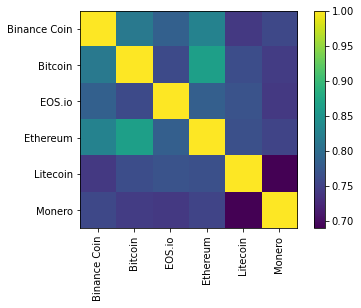

In [272]:
# check the correlation between each asset
labels=['Binance Coin','Bitcoin','EOS.io','Ethereum','Litecoin','Monero']
plt.imshow(all_assets.corr())
plt.yticks(range(6), labels)
plt.xticks(range(6), labels, rotation=90) 
plt.colorbar()

In [273]:
print(all_assets.corr())

              Binance Coin   Bitcoin    EOS.IO  Ethereum  Litecoin    Monero
Binance Coin      1.000000  0.815152  0.785339  0.827462  0.741223  0.757462
Bitcoin           0.815152  1.000000  0.758926  0.865003  0.763287  0.745212
EOS.IO            0.785339  0.758926  1.000000  0.783113  0.769019  0.741414
Ethereum          0.827462  0.865003  0.783113  1.000000  0.765917  0.752732
Litecoin          0.741223  0.763287  0.769019  0.765917  1.000000  0.689631
Monero            0.757462  0.745212  0.741414  0.752732  0.689631  1.000000


### 2. Visualize the close price of each asset in the last 3 months

In [274]:
times = score_df["timestamp"]
dates = times.apply(lambda d: datetime.utcfromtimestamp(d).strftime('%Y-%m-%d'))
dates

0         2021-06-21
1         2021-06-21
2         2021-06-21
3         2021-06-21
4         2021-06-21
             ...    
132475    2021-09-20
132476    2021-09-20
132477    2021-09-20
132478    2021-09-20
132479    2021-09-21
Name: timestamp, Length: 132480, dtype: object

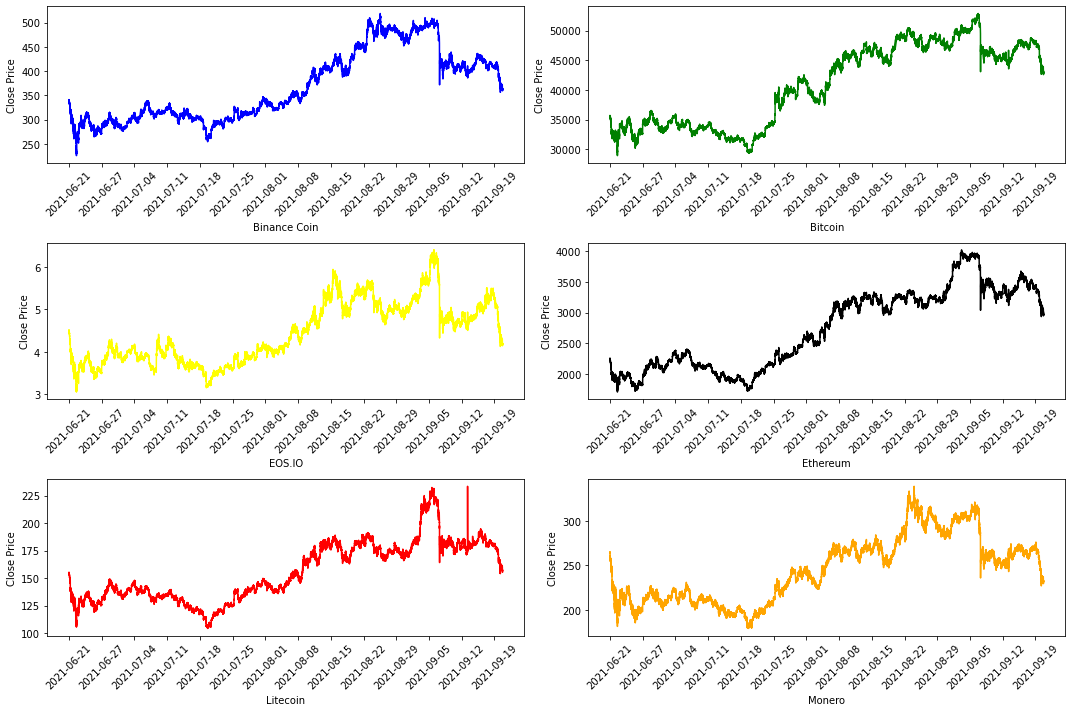

In [275]:
# visualize the close price of each cryptocurrencies in the last 3 months
fig = plt.figure(figsize=(15,10))
fig.add_subplot(321)
plt.plot(times, bnc_test['Close'], color="blue")
plt.xlabel('Binance Coin')
plt.ylabel('Close Price')
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(322)
plt.plot(times,bit_test['Close'], color="green")
plt.xlabel('Bitcoin')
plt.ylabel('Close Price')
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(323)
plt.plot(times,eos_test['Close'], color="yellow")
plt.xlabel('EOS.IO')
plt.ylabel('Close Price')
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(324)
plt.plot(times,eth_test['Close'], color="black")
plt.xlabel('Ethereum')
plt.ylabel('Close Price')
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(325)
plt.plot(times,lit_test['Close'], color="red")
plt.xlabel('Litecoin')
plt.ylabel('Close Price')
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(326)
plt.plot(times,mon_test['Close'], color="orange")
plt.xlabel('Monero')
plt.ylabel('Close Price')
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

plt.tight_layout()
plt.show()

### 3. Create the candlestick chart for last 3 months

In [261]:
# convert minutes data to daily data
bnc_test.reset_index(inplace=True)
bnc_test["date"]=pd.to_datetime(bnc_test["timestamp"], unit='s')
bnc_test.head()

/Users/yufengwu/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return,date
0,0,1624233660,0,296.0,339.9190,340.01,339.240,339.6760,623.416611,339.668832,0.000482,0.001812,2021-06-21 00:01:00
1,1,1624233720,0,2046.0,339.6825,342.00,339.675,341.3840,6182.884665,341.112575,0.001171,0.005213,2021-06-21 00:02:00
2,2,1624233780,0,1036.0,341.4175,342.00,340.995,341.2925,2485.581536,341.616181,0.000698,0.005811,2021-06-21 00:03:00
3,3,1624233840,0,862.0,341.3025,341.41,339.750,339.8510,1608.247226,340.667832,0.001799,0.001998,2021-06-21 00:04:00
4,4,1624233900,0,580.0,339.8740,340.28,339.380,339.4755,1493.521875,339.862421,0.002198,-0.000713,2021-06-21 00:05:00


In [259]:
cols = ['Open', 'High', 'Low', 'Close']
bnc_daily_price = bnc_test.groupby(pd.Grouper(freq='D', key='date')).mean()[cols]
bnc_daily_price

,Open,High,Low,Close
date,,,,
2021-06-21,309.530696,310.094880,308.933265,309.477793
2021-06-22,267.083007,267.780006,266.448086,267.093205
2021-06-23,289.119620,289.650689,288.616466,289.138807
2021-06-24,301.553758,301.965431,301.157397,301.556685
2021-06-25,293.107461,293.551430,292.621157,293.080339
...,...,...,...,...
2021-09-17,414.190533,414.492197,413.857896,414.180899
2021-09-18,413.473663,413.723285,413.221269,413.471362
2021-09-19,410.895177,411.126442,410.646383,410.892732


In [270]:
# create candlestick chart
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=bnc_daily_price.index, open=bnc_daily_price['Open'], high=bnc_daily_price['High'], low=bnc_daily_price['Low'], close=bnc_daily_price['Close'])])
fig.update_layout(
    title='Candlesticks chart for Binance Coin in last 3 months'
)
fig.show()

### 4. Visualize the prediction of each model

In [ ]:
# visualize the prediction of lineargression vs real return for each cryptocurrency
fig = plt.figure(figsize=(15,12))
fig.add_subplot(321)
plt.plot(times, y_bnc_test, 'b', label='bnc_test', alpha=0.7)
plt.plot(times, y_pred_lr_bnc, 'r', label='bnc_pred', alpha=0.7)
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Binance Coin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(322)
plt.plot(times, y_bit_test, 'b', label='bit_test', alpha=0.7)
plt.plot(times, y_pred_lr_bit, 'r', label='bit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Bitcoin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(323)
plt.plot(times, y_eos_test, 'b', label='eos_test', alpha=0.7)
plt.plot(times, y_pred_lr_eos, 'r', label='eos_pred', alpha=0.7)
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Target')
#plt.title("Predict vs Real return for EOS.IO from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(324)
plt.plot(times, y_eth_test, 'b', label='eth_test', alpha=0.7)
plt.plot(times, y_pred_lr_eth, 'r', label='eth_pred', alpha=0.7)
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Ethereum from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(325)
plt.plot(times, y_lit_test, 'b', label='lit_test', alpha=0.7)
plt.plot(times, y_pred_lr_lit, 'r', label='lit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Litecoin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(326)
plt.plot(times, y_mon_test, 'b', label='mon_test', alpha=0.7)
plt.plot(times, y_pred_lr_mon, 'r', label='mon_pred', alpha=0.7)
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Monero from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

plt.tight_layout()
plt.show()

In [ ]:
# visualize the prediction of randomforest vs real return for each cryptocurrency
fig = plt.figure(figsize=(15,12))
fig.add_subplot(321)
plt.plot(times, y_bnc_test, 'b', label='bnc_test', alpha=0.7)
plt.plot(times, y_pred_rf_bnc, 'r', label='bnc_pred', alpha=0.7)
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Binance Coin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(322)
plt.plot(times, y_bit_test, 'b', label='bit_test', alpha=0.7)
plt.plot(times, y_pred_rf_bit, 'r', label='bit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Bitcoin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(323)
plt.plot(times, y_eos_test, 'b', label='eos_test', alpha=0.7)
plt.plot(times, y_pred_rf_eos, 'r', label='eos_pred', alpha=0.7)
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Target')
#plt.title("Predict vs Real return for EOS.IO from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(324)
plt.plot(times, y_eth_test, 'b', label='eth_test', alpha=0.7)
plt.plot(times, y_pred_rf_eth, 'r', label='eth_pred', alpha=0.7)
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Ethereum from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(325)
plt.plot(times, y_lit_test, 'b', label='lit_test', alpha=0.7)
plt.plot(times, y_pred_rf_lit, 'r', label='lit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Litecoin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(326)
plt.plot(times, y_mon_test, 'b', label='mon_test', alpha=0.7)
plt.plot(times, y_pred_rf_mon, 'r', label='mon_pred', alpha=0.7)
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Monero from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

plt.tight_layout()
plt.show()

In [ ]:
# visualize the prediction of xgBoost vs real return for each cryptocurrency
fig = plt.figure(figsize=(15,12))
fig.add_subplot(321)
plt.plot(times, y_bnc_test, 'b', label='bnc_test', alpha=0.7)
plt.plot(times, y_pred_xg_bnc, 'r', label='bnc_pred', alpha=0.7)
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Binance Coin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(322)
plt.plot(times, y_bit_test, 'b', label='bit_test', alpha=0.7)
plt.plot(times, y_pred_xg_bit, 'r', label='bit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Bitcoin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(323)
plt.plot(times, y_eos_test, 'b', label='eos_test', alpha=0.7)
plt.plot(times, y_pred_xg_eos, 'r', label='eos_pred', alpha=0.7)
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Target')
#plt.title("Predict vs Real return for EOS.IO from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(324)
plt.plot(times, y_eth_test, 'b', label='eth_test', alpha=0.7)
plt.plot(times, y_pred_xg_eth, 'r', label='eth_pred', alpha=0.7)
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Ethereum from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(325)
plt.plot(times, y_lit_test, 'b', label='lit_test', alpha=0.7)
plt.plot(times, y_pred_xg_lit, 'r', label='lit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Litecoin from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(326)
plt.plot(times, y_mon_test, 'b', label='mon_test', alpha=0.7)
plt.plot(times, y_pred_xg_mon, 'r', label='mon_pred', alpha=0.7)
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Monero from 2021-06-21")
plt.xticks(times[0:-1:10000],dates[0:-1:10000], rotation = 45)

plt.tight_layout()
plt.show()

### 5. Show distribution of each aeest by boxplot

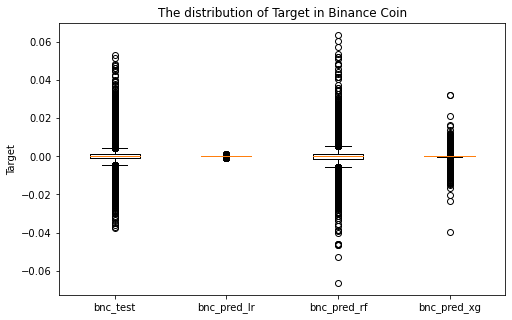

In [276]:
# show distribution of the outputs
plt.figure(figsize=(8,5))
x_labels = ["bnc_test", "bnc_pred_lr", "bnc_pred_rf", "bnc_pred_xg"]
data = score_df[["y_bnc_test","y_pred_lr_bnc","y_pred_rf_bnc","y_pred_xg_bnc"]] 
plt.boxplot(data, labels=x_labels)
plt.ylabel('Target')
plt.title("The distribution of Target in Binance Coin")
plt.show()

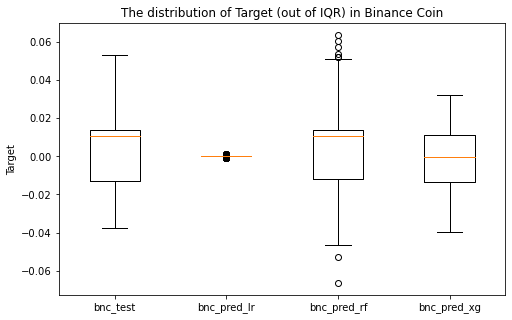

In [277]:
# show distribution of the outputs
plt.figure(figsize=(8,5))
x_labels = ["bnc_test", "bnc_pred_lr", "bnc_pred_rf", "bnc_pred_xg"]
data1 = np.array(score_df["y_bnc_test"])
data11 = data1[data1>0.01]
data12 = data1[data1<-0.01]
data1 = np.concatenate((data11,data12))
np.random.shuffle(data1)
data1 = data1[0:30000]

data2 = np.array(score_df["y_pred_lr_bnc"])
data21 = data2[data2>0.0001]
data22 = data2[data2<-0.0001]
data2 = np.concatenate((data21,data22))
np.random.shuffle(data2)
data2 = data2[0:30000]

data3 = np.array(score_df["y_pred_rf_bnc"])
data31 = data3[data3>0.01]
data32 = data3[data3<-0.01]
data3 = np.concatenate((data31,data32))
np.random.shuffle(data3)
data3 = data3[0:30000]

data4 = np.array(score_df["y_pred_xg_bnc"])
data41 = data4[data4>0.01]
data42 = data4[data4<-0.01]
data4 = np.concatenate((data41,data42))
np.random.shuffle(data4)
data4 = data4[0:30000]

data = [data1,data2,data3,data4] 
plt.boxplot(data, labels=x_labels)
plt.ylabel('Target')
plt.title("The distribution of Target (out of IQR) in Binance Coin")
plt.show()

## Future return prediction

## Connect to SQL Database

In [ ]:
# Connect to SQL Database

# YOUR CODE HERE